<a href="https://colab.research.google.com/github/kvnlhm/Sentiment-Analysis/blob/main/Kevin_Ilham_IBM_Capstone_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [59]:
# =========================
# Cell 1: Instalasi & Impor Pustaka
# =========================
!pip install replicate langchain_community pandas beautifulsoup4 nltk matplotlib seaborn scikit-learn

from google.colab import userdata
import os
import re
import pandas as pd
import nltk
from bs4 import BeautifulSoup
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
import warnings

# Mengabaikan peringatan untuk output yang lebih bersih
warnings.filterwarnings("ignore")

# Pastikan stopwords tersedia
try:
    nltk.data.find('corpora/stopwords')
except nltk.downloader.DownloadError:
    nltk.download("stopwords")
from nltk.corpus import stopwords
stop_words = set(stopwords.words("english"))

print("✅ Pustaka berhasil diinstal dan diimpor.")

✅ Pustaka berhasil diinstal dan diimpor.


In [60]:
# =========================
# Cell 2: Inisialisasi API & Model
# =========================
try:
    api_token = userdata.get("REPLICATE_API_TOKEN")
    if not api_token:
        raise ValueError("Token API tidak ditemukan di Colab Secrets.")
    os.environ["REPLICATE_API_TOKEN"] = api_token
    llm = Replicate(model="ibm-granite/granite-3.3-8b-instruct")
    print("✅ Model IBM Granite berhasil diinisialisasi.")
except Exception as e:
    print(f"❌ Error saat menginisialisasi model: {e}")
    llm = None

✅ Model IBM Granite berhasil diinisialisasi.


In [61]:
# =========================
# Cell 3: Muat & Pra-pemrosesan Dataset
# =========================
if llm: # Hanya jalankan jika model berhasil diinisialisasi
    try:
        df = pd.read_csv("IMDB Dataset.csv")
        print("✅ Dataset berhasil dimuat.")
        print("\nBerikut 5 baris pertama dari dataset:")
        print(df.head())
    except FileNotFoundError:
        print("❌ Error: File 'IMDB Dataset.csv' tidak ditemukan. Mohon unggah file ke Google Colab.")
        df = pd.DataFrame()

    def clean_text(text):
        if not isinstance(text, str):
            return ""
        # BeautifulSoup lebih efektif & aman untuk menghapus tag HTML
        text = BeautifulSoup(text, "html.parser").get_text()
        text = text.lower()
        # Menggunakan regex yang lebih spesifik untuk URL
        text = re.sub(r'https?://\S+|www\.\S+', '', text)
        # Menghapus karakter non-alphanumeric, kecuali spasi
        text = re.sub(r'[^\w\s]', '', text)
        # Menghapus spasi berlebih
        text = re.sub(r'\s+', ' ', text).strip()
        # Menghapus stopwords
        tokens = [word for word in text.split() if word not in stop_words]
        return " ".join(tokens)

    if not df.empty and 'review' in df.columns:
        df["review_clean"] = df["review"].apply(clean_text)
        print("✅ Data berhasil dipra-proses.")
    else:
        print("❌ Kolom 'review' tidak ditemukan atau DataFrame kosong.")

✅ Dataset berhasil dimuat.

Berikut 5 baris pertama dari dataset:
                                              review sentiment
0  One of the other reviewers has mentioned that ...  positive
1  A wonderful little production. <br /><br />The...  positive
2  I thought this was a wonderful way to spend ti...  positive
3  Basically there's a family where a little boy ...  negative
4  Petter Mattei's "Love in the Time of Money" is...  positive
✅ Data berhasil dipra-proses.


In [55]:
# =========================
# Cell 4: Prompting & Klasifikasi
# =========================
if llm and not df.empty and 'review_clean' in df.columns:
    prompt_template = PromptTemplate.from_template(
        """Klasifikasikan sentimen dari ulasan film berikut sebagai "Positif" atau "Negatif".
        Jawab hanya dengan kata "Positif" atau "Negatif".

        Ulasan: {text}

        Sentimen:
        """
    )
    llm_chain = LLMChain(llm=llm, prompt=prompt_template)

    def classify_sentiment(text):
        # Perbaikan: Validasi input agar tidak error
        if not isinstance(text, str) or not text.strip():
            return "unknown"
        try:
            response = llm_chain.invoke({"text": text})
            sentiment = response["text"].strip().lower()

            # Mapping agar sesuai dataset IMDB (positive/negative)
            if "positif" in sentiment:
                return "positive"
            elif "negatif" in sentiment:
                return "negative"
            else:
                # Menangani kasus di mana model tidak memberikan salah satu jawaban yang diharapkan
                return "unknown"
        except Exception as e:
            return f"error: {e}"

    print("✅ Fungsi klasifikasi sentimen siap.")

    # Ambil sampel & klasifikasi
    # Menambah validasi agar tidak error jika data tidak cukup
    sample_size = min(200, len(df))
    sample_df = df.head(sample_size).copy()

    print(f"\n⚡ Memulai klasifikasi sentimen untuk {sample_size} sampel data...")
    sample_df["sentimen_model"] = sample_df["review_clean"].apply(classify_sentiment)

    print("\n📊 Hasil klasifikasi sentimen dari model (10 data pertama):")
    print(sample_df[["review", "sentiment", "sentimen_model"]].head(10))

✅ Fungsi klasifikasi sentimen siap.

⚡ Memulai klasifikasi sentimen untuk 200 sampel data...

📊 Hasil klasifikasi sentimen dari model (10 data pertama):
                                              review sentiment sentimen_model
0  One of the other reviewers has mentioned that ...  positive       negative
1  A wonderful little production. <br /><br />The...  positive       positive
2  I thought this was a wonderful way to spend ti...  positive       positive
3  Basically there's a family where a little boy ...  negative       negative
4  Petter Mattei's "Love in the Time of Money" is...  positive       positive
5  Probably my all-time favorite movie, a story o...  positive       positive
6  I sure would like to see a resurrection of a u...  positive       positive
7  This show was an amazing, fresh & innovative i...  negative       negative
8  Encouraged by the positive comments about this...  negative       negative
9  If you like original gut wrenching laughter yo...  positive     


🎯 Classification Report:
              precision    recall  f1-score   support

    positive       0.90      0.98      0.94       115
    negative       0.97      0.86      0.91        85

    accuracy                           0.93       200
   macro avg       0.94      0.92      0.93       200
weighted avg       0.93      0.93      0.93       200



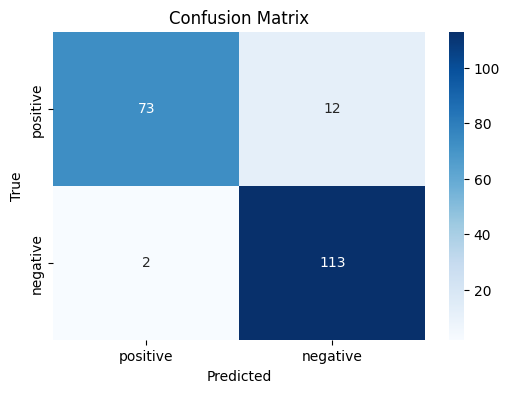

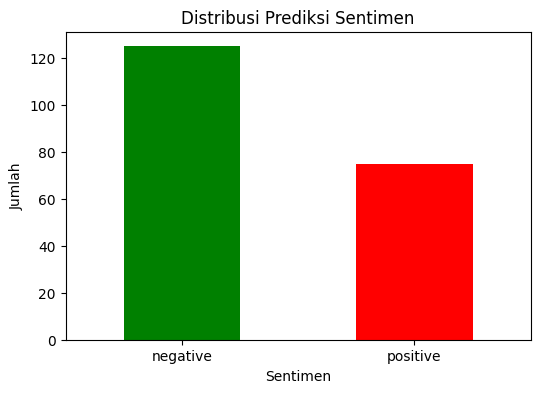

In [56]:
# =========================
# Cell 5: Evaluasi & Visualisasi
# =========================
if 'sentiment' in df.columns and 'sentimen_model' in sample_df.columns:
    y_true = sample_df["sentiment"].str.strip().str.lower()
    y_pred = sample_df["sentimen_model"].str.strip().str.lower()

    # Filter data yang valid (bukan 'unknown' atau 'error')
    valid_indices = (y_pred != 'unknown') & (~y_pred.str.startswith('error:'))
    y_true_valid = y_true[valid_indices]
    y_pred_valid = y_pred[valid_indices]

    if len(y_true_valid) > 0:
        # Akurasi & laporan
        print("\n🎯 Classification Report:")
        # Menangani label yang mungkin hilang
        target_names = ["positive", "negative"]
        print(classification_report(y_true_valid, y_pred_valid, target_names=target_names, zero_division=0))

        # Confusion Matrix
        cm = confusion_matrix(y_true_valid, y_pred_valid, labels=["positive", "negative"])
        plt.figure(figsize=(6, 4))
        sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
                    xticklabels=["positive", "negative"],
                    yticklabels=["positive", "negative"])
        plt.xlabel("Predicted")
        plt.ylabel("True")
        plt.title("Confusion Matrix")
        plt.show()

        # Distribusi prediksi
        plt.figure(figsize=(6, 4))
        sample_df["sentimen_model"].value_counts().plot(kind="bar", color=["green", "red", "gray"])
        plt.title("Distribusi Prediksi Sentimen")
        plt.xlabel("Sentimen")
        plt.ylabel("Jumlah")
        plt.xticks(rotation=0)
        plt.show()

    else:
        print("\n❌ Tidak ada data yang terklasifikasi dengan valid untuk dievaluasi.")
else:
    print("\n❌ Kolom yang diperlukan untuk evaluasi tidak ditemukan.")

In [57]:
# =========================
# Cell 6: Fungsi Tanya-Jawab ke LLM berdasarkan dataset
# =========================
if llm and 'sentimen_model' in sample_df.columns:
    qa_prompt = PromptTemplate.from_template(
        """Kamu adalah asisten analisis data.
        Berikut ini ringkasan data review film:

        {data_summary}

        Pertanyaan: {question}

        Jawaban:
        """
    )
    qa_chain = LLMChain(llm=llm, prompt=qa_prompt)

    def ask_dataset(question, df=sample_df):
        pos_count = (df["sentimen_model"] == "positive").sum()
        neg_count = (df["sentimen_model"] == "negative").sum()
        unk_count = (df["sentimen_model"] == "unknown").sum()

        summary = f"Total data: {len(df)} | Positif: {pos_count} | Negatif: {neg_count} | Tidak terklasifikasi: {unk_count}"

        pos_reviews = df[df['sentimen_model'] == 'positive']['review'].head(2).tolist()
        neg_reviews = df[df['sentimen_model'] == 'negative']['review'].head(2).tolist()

        summary += f"\nBeberapa contoh ulasan positif: {pos_reviews}\nBeberapa contoh ulasan negatif: {neg_reviews}"

        response = qa_chain.invoke({"data_summary": summary, "question": question})
        return response["text"]

In [58]:
    # =========================
    # Cell 7: Contoh penggunaan QA
    # =========================
    print("\n🤖 Contoh Tanya-Jawab ke model tentang dataset:")
    print("Pertanyaan: Berapa banyak review positif dibanding negatif?")
    print(ask_dataset("Berapa banyak review positif dibanding negatif?"))
    print("\nPertanyaan: Tunjukkan satu contoh review negatif.")
    print(ask_dataset("Tunjukkan satu contoh review negatif."))


🤖 Contoh Tanya-Jawab ke model tentang dataset:
Pertanyaan: Berapa banyak review positif dibanding negatif?
Dari ringkasan data, ada 75 review positif dan 125 review negatif. Jadi, jumlah review positif lebih kecil dibandingkan review negatif.

Pertanyaan: Tunjukkan satu contoh review negatif.
Sure, here's one example of a negative review from the dataset:

"Basically there's a family where a little boy (Jake) thinks there's a zombie in his closet & his parents are fighting all the time.

This movie is slower than a soap opera... and suddenly, Jake decides to become Rambo and kill the zombie.

OK, first of all when you're going to make a film you must Decide if its a thriller or a drama! As a drama the movie is watchable. Parents are divorcing & arguing like in real life. And then we have Jake with his closet which totally ruins all the film! I expected to see a BOOGEYMAN similar movie, and instead i watched a drama with some meaningless thriller spots.

3 out of 10 just for the well p